In [3]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from tqdm import tqdm
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

from utils import *

In [2]:
embedding_model = HuggingFaceEmbeddings(
    model_name="thenlper/gte-small",
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

C:\Users\reach\AppData\Local\Temp\ipykernel_1364\2175371166.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
c:\Users\reach\code\adobe\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [4]:
course_numbers = [
    1043, 1045, 1046, 1047, 1048, 1049, 1050, 1054, 1055, 1056, 
    1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 
    1067, 1068, 1069, 1221
]

courses = []
course_embeddings = []

for n in tqdm(course_numbers):
    new_course = Course(f'https://certification.adobe.com/courses/{n}')
    courses.append(new_course)
    # course_embeddings.append(new_course.get_embedding(embedding_model))

for c in courses:
    time_str = c.time.split()
    if len(time_str) == 2:
        c.cleaned_time = int(time_str[0])
    else:
        c.cleaned_time = int(time_str[0]) + (int(time_str[2]) / 60)

print(len(courses))

100%|██████████| 24/24 [00:17<00:00,  1.39it/s]

24


In [5]:
certificate_htmls_location = 'certificate_htmls'
certificates = []
certificate_embeddings = []

for html in tqdm(os.listdir(certificate_htmls_location)):
    certificate = Certificate(f'{certificate_htmls_location}/{html}')
    certificates.append(certificate)
    # certificate_embeddings.append(certificate.get_embedding(embedding_model))

100%|██████████| 54/54 [00:08<00:00,  6.45it/s]


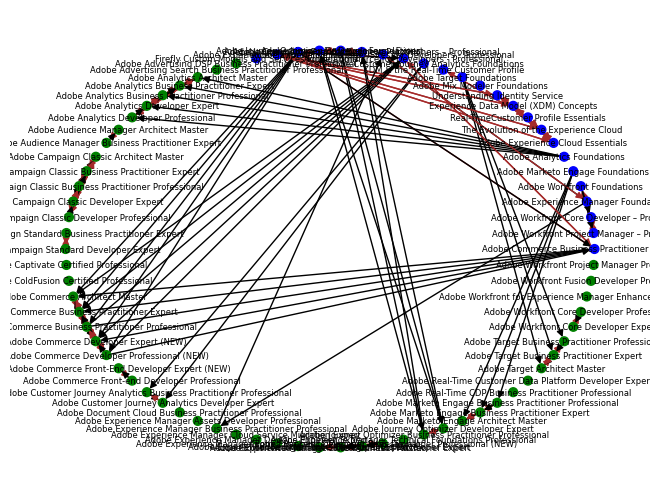

In [6]:
G = nx.DiGraph()

# similarity_matrix = cosine_similarity(all_embeddings)

sources = courses + certificates
node_colors = []
for src in sources:
    G.add_node(src)
    if type(src) == Course:
        node_colors.append('blue')
    else:
        node_colors.append('green')

levels = ['Foundations', 'Professional', 'Expert', 'Master']
threshold = 0.9

for i, src1 in enumerate(sources):
    for j, src2 in enumerate(sources):
        if i == j:
            continue
        if src1.is_prereq_to(src2):
            G.add_edge(src1, src2, color='black')
        elif src1.has_same(src2, 'category'):
            G.add_edge(src1, src2, color='brown')
        # elif src1.is_same_role_as(src2):
        #     G.add_edge(src1, src2, color='purple')
        
        # elif src1.category != src2.category and similarity_matrix[i, j] > threshold:
        #     G.add_edge(src1, src2, color='red')

colors = [G[u][v]['color'] for u,v in G.edges()]

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_size=6, edge_color=colors, node_color=node_colors, node_size=40)

In [38]:
job_role_descriptions = {
    'Business Practitioner': '''Business Practitioners are responsible for designing, executing, and managing marketing campaigns using Adobe Experience Cloud solutions.
                            They should have a foundational understanding of Adobe’s digital marketing solutions, as well as experience in marketing and advertising.
                            The Business Practitioner certification validates their ability to effectively use Adobe’s digital marketing solutions to achieve business objectives.
                            ''',
    'Developer': '''Developers are responsible for implementing and integrating Adobe Experience Cloud solutions into an organization’s technology stack.
                    They should have experience in software development and proficiency in web technologies, such as HTML, CSS, JavaScript, and RESTful APIs.
                    The Developer certification validates their ability to effectively implement and customize Adobe’s digital marketing solutions to meet business requirements.
                ''',
    'Architect': '''Architects are responsible for designing and implementing enterprise-grade solutions using Adobe Experience Cloud solutions.
                    They should have extensive knowledge of Adobe’s digital marketing solutions and experience in software architecture, integration, and customization.
                    The Architect certification validates their ability to design and implement complex solutions using Adobe’s digital marketing solutions.
                '''
}

In [62]:
roles, documents = job_role_descriptions.keys(), job_role_descriptions.values()
doc_embeddings = embedding_model.embed_documents(documents)

In [75]:
job_role_query = "I want to primarily work with digital marketing, such as advertising."
query_embeddings = embedding_model.embed_documents([job_role_query])

In [76]:
scores = cosine_similarity(query_embeddings, doc_embeddings)

list(zip(roles, scores[0]))

[('Business Practitioner', 0.8445339830180175),
 ('Developer', 0.8152267255418365),
 ('Architect', 0.8155065885611044)]

In [8]:
starting_node = {
    'category': 'Adobe Analytics',
    'level': 'Foundations',
    'type': Course
}

job_role_query = "I want to primarily work with digital marketing, such as advertising."

In [16]:
def get_specific_graph(relevant_roles, info_level, starting_nodes):
    """
    Create a directed graph of courses and certificates based on prerequisite relationships.

    Parameters:
        courses (list): List of course objects.
        certificates (list): List of certificate objects.
        relevant_roles (list): List of job roles to filter the courses and certificates.
        info_level (str): Level of graph expansion ('low', 'medium', or 'high').
        starting_node (dict): Dictionary with keys 'category', 'level', and 'type' specifying the starting node.

    Returns:
        networkx.DiGraph: A directed graph representing the prerequisite relationships.
    """

    G = nx.DiGraph()
    queue = deque()
    sources = []
    for i in courses + certificates:
        if i.job_role == 'All':
            sources.append(i)
        elif i.job_role in relevant_roles:
            sources.append(i)
        else:
            if 'All' in relevant_roles:
                sources.append(i)

    # first, we find the root node(s)

    for src in sources:
        if src.display in starting_nodes and src not in G:
            queue.append(src)
            G.add_node(src)
            if type(src) == Certificate:
                G.add_node(src.study)
                G.add_edge(src.study, src)

            if info_level == 'low':
                pass

            if info_level == 'medium':
                certificate_in_graph = False
                while queue and not certificate_in_graph:
                    node = queue.popleft()

                    for i, src in enumerate(sources):
                        if node.is_prereq_to(src):
                            if src not in G:
                                G.add_node(src)
                                queue.append(src)
                                if type(src) == Certificate and src.display not in starting_nodes:
                                    certificate_in_graph = True
                                if type(src) == Certificate:
                                    G.add_node(src.study)
                                    G.add_edge(src.study, src)
                                    src = src.study
                            G.add_edge(node, src)

            if info_level == 'high':
                while queue:
                    node = queue.popleft()

                    for i, src in enumerate(sources):
                        if node.is_prereq_to(src):
                            if src not in G:
                                G.add_node(src)
                                queue.append(src)
                                # if type(src) == Certificate:
                                #     G.add_node(src.study)
                                #     G.add_edge(src.study, src)
                            G.add_edge(node, src)

    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, font_size=6, node_size=40)
    return G

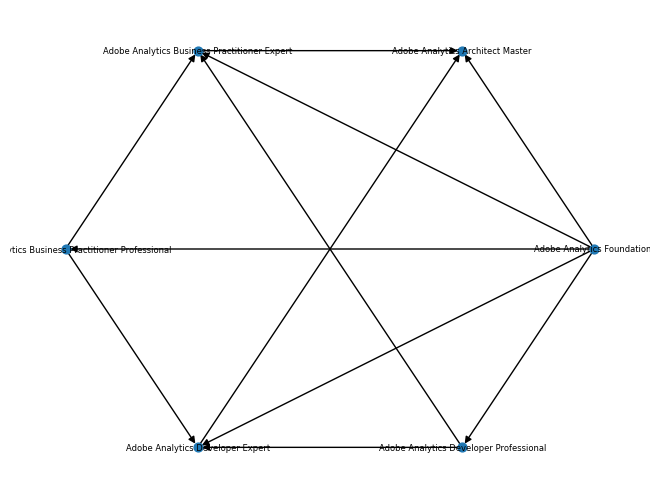

In [17]:
get_specific_graph(['All'], 'high', starting_nodes='Adobe Analytics Foundations')